In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle, \
                        runningfix_directbearing_mle, runningfix_directrange_mle

from simulation import Simulation, generate_simulation_clocks

In [2]:
iterations = 1000

### world parameters
sim = Simulation(weather        = "clear", 
                 temperature    = 298,   # [K], circuit temperature
                 daynight       = "day_indirectsun", 
                 rxconfig       = "optics/qrx_planoconvex.npz", 
                 txconfig       = "optics/tx_lambertian_20deg_2W.npz", 
                 istxlambertian = True, 
                 f_adc_clk      = 1.0e7,  # [Hz] ADC measurement clock freq
                 f_e            = 1.0e6,  # [Hz] emitted wave freq, left TX
                 f_sim          = 1.0e10) # [Hz] simulation master clock freq

L_ego    = 1.6 # [m]
L_target = 1.5 # [m] arbitrary selection, just to make it different than the ego. This is not known, so it's not used in the algo

### build lane change trajectory similar to the PIMRC article
# starts with constant heading, sliding, then starts to level out with changing heading (a curved portion at the end on xy plane)
trj_numsamples = 1000 # will correspond to 1s of simulation since vehicle timing in simulations are sampled at 1kHz
xRL_to_rxL     = np.concatenate((np.linspace(-1, 1, int(trj_numsamples/2)), np.linspace(1, 3, int(trj_numsamples/2))  ))
curved_portion = np.linspace(1,3, int(trj_numsamples/2))**1.2
yRL_to_rxL     = np.concatenate((np.linspace(5, 7, int(trj_numsamples/2)), curved_portion+6 ))

ha  = 5 # start heading
hh  = np.linspace(ha,4,int(trj_numsamples/2)) # curved portion has linearly changing heading
hdg = np.concatenate( (np.ones((int(trj_numsamples/2)))*ha, hh) )

xRR_to_rxL = np.concatenate( (xRL_to_rxL[0:int(trj_numsamples/2)] + L_target*np.cos(np.deg2rad(ha)) , 
                              xRL_to_rxL[int(trj_numsamples/2):] + L_target*np.cos(np.deg2rad(hh))) )

yRR_to_rxL = np.concatenate( (yRL_to_rxL[0:int(trj_numsamples/2)] + L_target*np.sin(np.deg2rad(ha)) , 
                              yRL_to_rxL[int(trj_numsamples/2):] + L_target*np.sin(np.deg2rad(hh))) )

xRL_to_rxR = xRL_to_rxL - L_ego
yRL_to_rxR = yRL_to_rxL
xRR_to_rxR = xRR_to_rxL - L_ego
yRR_to_rxR = yRR_to_rxL

### simulation timing parameters, generate simulation clocks
# define a special "vehicle clock" to follow the trajectory
f_vehicle = 1e3;         # [Hz], trajectory simulation clock rate, fixed by trajectory generation
t_vehicle = 1/f_vehicle; # [s] , trajectory simulation clock period, fixed by trajectory generation
t_sim_stop = t_vehicle*trj_numsamples
s_veh_clock = generate_simulation_clocks(t_sim_stop, sim.f_simulation, f_vehicle, gen_clocked_only=True)

localization_decimation_rate = 10 # to get VLP rate = 100 Hz
localization_rate = 1/(t_vehicle*localization_decimation_rate)
localization_num_steps = int(trj_numsamples/localization_decimation_rate)

s_adc_clock = generate_simulation_clocks(t_sim_stop, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)

In [3]:
### simulate received power
pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, np.zeros_like(yRL_to_rxL), hdg, sim)
pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, np.zeros_like(yRL_to_rxR), hdg, sim)
pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, np.zeros_like(yRR_to_rxL), hdg, sim)
pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, np.zeros_like(yRR_to_rxR), hdg, sim)

shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxR)

delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, sim.lightspeed)
delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, sim.lightspeed)
delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, sim.lightspeed)
delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, sim.lightspeed)

In [4]:
### run simulation over the list of points
aoa_rxL_txL     = np.zeros((localization_num_steps)); aoa_rxR_txL     = np.zeros((localization_num_steps))
aoa_rxL_txR     = np.zeros((localization_num_steps)); aoa_rxR_txR     = np.zeros((localization_num_steps))
delaoa_rxLR_txL = np.zeros((localization_num_steps)); delaoa_rxLR_txR = np.zeros((localization_num_steps))
d_rxL_txL       = np.zeros((localization_num_steps)); d_rxR_txL       = np.zeros((localization_num_steps))
d_rxL_txR       = np.zeros((localization_num_steps)); d_rxR_txR       = np.zeros((localization_num_steps))
deld_rxLR_txL   = np.zeros((localization_num_steps)); deld_rxLR_txR   = np.zeros((localization_num_steps))

run_rxL_x_directbearing = np.zeros((localization_num_steps, iterations)); 
run_rxL_y_directbearing = np.zeros((localization_num_steps, iterations));
run_rxL_x_directrange   = np.zeros((localization_num_steps, iterations)); 
run_rxL_y_directrange   = np.zeros((localization_num_steps, iterations));
cls_x_directbearing     = np.zeros((localization_num_steps, iterations)); 
cls_y_directbearing     = np.zeros((localization_num_steps, iterations));
cls_x_diffbearing       = np.zeros((localization_num_steps, iterations)); 
cls_y_diffbearing       = np.zeros((localization_num_steps, iterations));
cls_x_directrange       = np.zeros((localization_num_steps, iterations)); 
cls_y_directrange       = np.zeros((localization_num_steps, iterations));
cls_x_diffrange         = np.zeros((localization_num_steps, iterations)); 
cls_y_diffrange         = np.zeros((localization_num_steps, iterations));

for j in tqdm(range(0,iterations)):
    for i in range(0, localization_num_steps):
        smp_lo = i*localization_decimation_rate
        smp_hi = (i+1)*localization_decimation_rate

        step_time       = s_veh_clock[smp_lo:smp_hi]
        simulation_time = s_adc_clock[int(i*sim.f_adc_clock/f_vehicle):int((i+1)*sim.f_adc_clock/f_vehicle)]

        rxLL, rxLR, rxRL, rxRR, delays = gen_qrx_onlyclocked(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, 
                                                             shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                             delay_txL_to_rxL, delay_txL_to_rxR, 
                                                             delay_txR_to_rxL, delay_txR_to_rxR, sim, step_time, 
                                                             simulation_time, smp_lo, smp_hi);
        (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
        (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
        (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
        (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
        (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays

        del rxLL, rxLR, rxRL, rxRR, delays 

        # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
        # which is 1 delay earlier than echo transmission from target vehicle)
        wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLL_sigTime))
        wav_rxL_txR = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayRL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLR_sigTime))
        wav_rxR_txR = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayRR_sigTime))

        d_rxL_txL[i] = measure_range_roberts(rxLA_txL + rxLB_txL + rxLC_txL + rxLD_txL, wav_rxL_txL, sim.lightspeed, sim.f_emitted)
        d_rxR_txL[i] = measure_range_roberts(rxRA_txL + rxRB_txL + rxRC_txL + rxRD_txL, wav_rxR_txL, sim.lightspeed, sim.f_emitted)
        d_rxL_txR[i] = measure_range_roberts(rxLA_txR + rxLB_txR + rxLC_txR + rxLD_txR, wav_rxL_txR, sim.lightspeed, sim.f_emitted)
        d_rxR_txR[i] = measure_range_roberts(rxRA_txR + rxRB_txR + rxRC_txR + rxRD_txR, wav_rxR_txR, sim.lightspeed, sim.f_emitted)

        deld_rxLR_txL[i] = d_rxL_txL[i] - d_rxR_txL[i]
        deld_rxLR_txR[i] = d_rxL_txR[i] - d_rxR_txR[i]
        
        thd = 1e-5; # just to avoid messing up the graphs when aoa detection is too bad.
        # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
        # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
        wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLL_sigTime))
        wav_rxL_txR = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayRL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLR_sigTime))
        wav_rxR_txR = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayRR_sigTime))
        aoa_rxL_txL[i] = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, sim.rx_config_bundle["f_QRX"], thd)
        aoa_rxL_txR[i] = measure_bearing(rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR, wav_rxL_txR, sim.rx_config_bundle["f_QRX"], thd)
        aoa_rxR_txL[i] = measure_bearing(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, sim.rx_config_bundle["f_QRX"], thd)
        aoa_rxR_txR[i] = measure_bearing(rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR, wav_rxR_txR, sim.rx_config_bundle["f_QRX"], thd)

        delaoa_rxLR_txL[i] = aoa_rxL_txL[i] - aoa_rxR_txL[i];
        delaoa_rxLR_txR[i] = aoa_rxL_txR[i] - aoa_rxR_txR[i];
        
        cls_x_directbearing[i,j], cls_y_directbearing[i,j] = classicalfix_directbearing_mle(aoa_rxL_txL[i], aoa_rxR_txL[i], L_ego)
        cls_x_diffbearing[i,j], cls_y_diffbearing[i,j]     = classicalfix_diffbearing_mle(delaoa_rxLR_txL[i], delaoa_rxLR_txR[i], L_ego)
        cls_x_directrange[i,j], cls_y_directrange[i,j]     = classicalfix_directrange_mle(d_rxL_txL[i], d_rxR_txL[i], L_ego)
        cls_x_diffrange[i,j], cls_y_diffrange[i,j]         = classicalfix_diffrange_mle(deld_rxLR_txL[i], deld_rxLR_txR[i], L_ego)
        
        if(np.mod(i,2)==1):
            dv_ns_stdev = 0.00083 # tabulated sensor data, see references on the article
            dv = np.sqrt((xRL_to_rxL[smp_hi-1] - xRL_to_rxL[smp_lo-1])**2 + (yRL_to_rxL[smp_hi-1] - yRL_to_rxL[smp_lo-1])**2) + \
                          dv_ns_stdev*np.random.randn(1);
            av_ns_stdev = np.deg2rad(0.02) # tabulated sensor data, see references on the article
            av = np.arctan2((xRL_to_rxL[smp_hi-1] - xRL_to_rxL[smp_lo-1]),(yRL_to_rxL[smp_hi-1] - yRL_to_rxL[smp_lo-1])) + \
                             av_ns_stdev*np.random.randn(1);

            run_rxL_x_directbearing[i-1,j], run_rxL_y_directbearing[i-1,j], \
            run_rxL_x_directbearing[i,j], run_rxL_y_directbearing[i,j] = runningfix_directbearing_mle(aoa_rxL_txL[i-1], 
                                                                                                      aoa_rxL_txL[i], dv, av)
            run_rxL_x_directrange[i-1,j], run_rxL_y_directrange[i-1,j], \
            run_rxL_x_directrange[i,j], run_rxL_y_directrange[i,j] = runningfix_directrange_mle(d_rxL_txL[i-1], 
                                                                                                d_rxL_txL[i], dv, av)

100%|███████████████████████████████████████| 1000/1000 [10:41<00:00,  1.56it/s]


In [5]:
e_cls_x_directbearing = np.zeros((localization_num_steps, iterations))
e_cls_y_directbearing = np.zeros((localization_num_steps, iterations))
e_cls_x_diffbearing = np.zeros((localization_num_steps, iterations))
e_cls_y_diffbearing = np.zeros((localization_num_steps, iterations))
e_cls_x_directrange = np.zeros((localization_num_steps, iterations))
e_cls_y_directrange = np.zeros((localization_num_steps, iterations))
e_cls_x_diffrange = np.zeros((localization_num_steps, iterations))
e_cls_y_diffrange = np.zeros((localization_num_steps, iterations))
e_run_rxL_x_directbearing = np.zeros((localization_num_steps, iterations))
e_run_rxL_y_directbearing = np.zeros((localization_num_steps, iterations))
e_run_rxL_x_directrange = np.zeros((localization_num_steps, iterations))
e_run_rxL_y_directrange = np.zeros((localization_num_steps, iterations))
for k in range(0,iterations):
    e_cls_x_directbearing[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_x_directbearing[:,k]
    e_cls_y_directbearing[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_y_directbearing[:,k]
    e_cls_x_diffbearing[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_x_diffbearing[:,k]
    e_cls_y_diffbearing[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_y_diffbearing[:,k]
    e_cls_x_directrange[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_x_directrange[:,k]
    e_cls_y_directrange[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_y_directrange[:,k]
    e_cls_x_diffrange[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_x_diffrange[:,k]
    e_cls_y_diffrange[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - cls_y_diffrange[:,k]
    e_run_rxL_x_directbearing[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_x_directbearing[:,k]
    e_run_rxL_y_directbearing[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_y_directbearing[:,k]
    e_run_rxL_x_directrange[:,k] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_x_directrange[:,k]
    e_run_rxL_y_directrange[:,k] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_y_directrange[:,k]

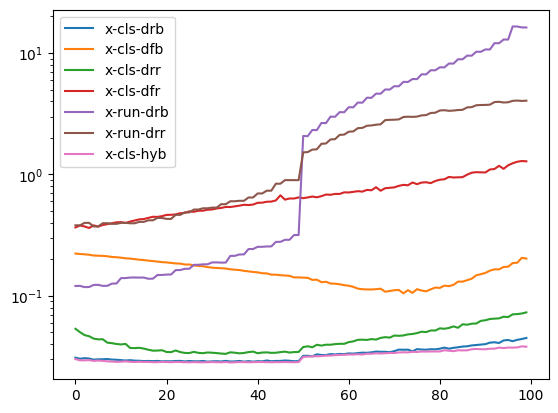

In [8]:
plt.semilogy(np.mean(np.sqrt(e_cls_x_directbearing**2 + e_cls_y_directbearing**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_cls_x_diffbearing**2 + e_cls_y_diffbearing**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_cls_x_directrange**2 + e_cls_y_directrange**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_cls_x_diffrange**2 + e_cls_y_diffrange**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_run_rxL_x_directbearing**2 + e_run_rxL_y_directbearing**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_run_rxL_x_directrange**2 + e_run_rxL_y_directrange**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_cls_x_directbearing**2 + e_cls_y_directrange**2),axis=-1))
plt.legend(["x-cls-drb", "x-cls-dfb", "x-cls-drr", "x-cls-dfr", "x-run-drb", "x-run-drr", "x-cls-hyb"])

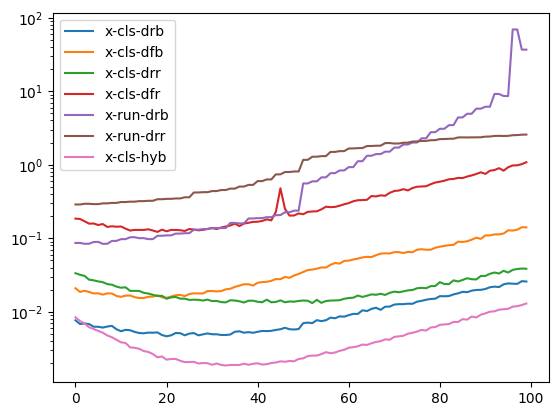

In [9]:
plt.semilogy(np.std(np.sqrt(e_cls_x_directbearing**2 + e_cls_y_directbearing**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_cls_x_diffbearing**2 + e_cls_y_diffbearing**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_cls_x_directrange**2 + e_cls_y_directrange**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_cls_x_diffrange**2 + e_cls_y_diffrange**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_run_rxL_x_directbearing**2 + e_run_rxL_y_directbearing**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_run_rxL_x_directrange**2 + e_run_rxL_y_directrange**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_cls_x_directbearing**2 + e_cls_y_directrange**2),axis=-1))
plt.legend(["x-cls-drb", "x-cls-dfb", "x-cls-drr", "x-cls-dfr", "x-run-drb", "x-run-drr", "x-cls-hyb"])